In [1]:
! pip install -q -U tensorflow-text
! pip install -q tf-models-official


     |████████████████████████████████| 4.4 MB 8.6 MB/s 


In [1]:
from os import path, listdir
import shutil
from typing import *
from ast import literal_eval

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


In [2]:
class IMDB_Dataset(object):
    def __init__(self, batch_size: int, seed: int):
        self.source = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
        self.__load()
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.batch_size = batch_size
        self.seed = seed

    def __load(self):
        """
        Checks if aclImdb dir was created previously or not. If not, the data is downloaded from self.source and the path is created.
        aclImdb will have two subdirs, "train" and "test"
        """
        #---------------------------------
        def download_data():
            self.data = tf.keras.utils.get_file('aclImdb_v1.tar.gz', self.source, untar=True, cache_dir='.', cache_subdir='')
            self.data_path = path.join(path.dirname(self.data), 'aclImdb')
            self.train_path = path.join(self.data_path, 'train')
            shutil.rmtree(path.join(self.train_path, 'unsup'))
        #---------------------------------
        if not path.exists("aclImdb"):
            download_data()
        else:
            imdb_dir = listdir("aclImdb")
            if not "test" in imdb_dir or not "train" in imdb_dir:
                download_data()
    
    def generate(self, val_split_perc: float):
        raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'aclImdb/train',
            batch_size=self.batch_size,
            validation_split=val_split_perc,
            subset='training',
            seed=self.seed
            )
        
        self.classes = raw_train_ds.class_names
        self.train_ds = raw_train_ds.cache().prefetch(buffer_size=self.AUTOTUNE)
        self.val_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'aclImdb/train',
            batch_size=self.batch_size,
            validation_split=val_split_perc,
            subset='validation',
            seed=self.seed
            ).cache().prefetch(buffer_size=self.AUTOTUNE)

        self.test_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'aclImdb/test',
            batch_size=self.batch_size
            ).cache().prefetch(buffer_size=self.AUTOTUNE)
        
        
        
def get_bert_model(model_name: str, path: str = "") -> tuple:
    if path:
        handler_path = f"{path}/bert_handler.txt"
        preprocess_path = f"{path}/bert_preprocess.txt"
        files = listdir(path)
    else:
        handler_path, preprocess_path = "bert_handler.txt", "bert_preprocess.txt"
        files = listdir()
    assert handler_path.split("/")[-1] in files and preprocess_path.split("/")[-1] in files, "Could not find bert_handler.txt or bert_preprocess.txt in {}".format(path)
    with open(handler_path, "r") as f:
        bert_handle_map = literal_eval(f.read())
    with open(preprocess_path, "r") as f:
        bert_preprocess_map = literal_eval(f.read())
    
    encoder, preprocesser = bert_handle_map[model_name], bert_preprocess_map[model_name]
    bert_pp_model = hub.KerasLayer(preprocesser) #preprocessing for bert
    bert_encoder_model = hub.KerasLayer(encoder, trainable=True)   #bert model
    return bert_pp_model, bert_encoder_model




class BuildClassifier:
    def __init__(self, 
                 preprocessing: hub.keras_layer.KerasLayer, 
                 model: hub.keras_layer.KerasLayer):
        self.preprocessing = preprocessing
        self.model = model
    
    def build(self) -> tf.keras.Model:
        text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_layer')
        pp_layer = hub.KerasLayer(self.preprocessing, name='preprocessing_layer')
        encoder_inputs = pp_layer(text)
        encoder = hub.KerasLayer(self.model, trainable=True, name='BERT_Encoder')
        outputs = encoder(encoder_inputs)
        clf_net = outputs['pooled_output']
        clf_net = tf.keras.layers.Dropout(0.1)(clf_net)
        clf_net = tf.keras.layers.Dense(1, activation=None, name='Classifier')(clf_net)
        return tf.keras.Model(text, clf_net)




In [3]:
BATCH_SIZE = 32
SEED = 42

data = IMDB_Dataset(batch_size=BATCH_SIZE, seed=SEED)
data.generate(val_split_perc=0.2)
data.classes


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


['neg', 'pos']

In [4]:
bert_preprocessing, bert_model = get_bert_model('small_bert/bert_en_uncased_L-4_H-512_A-8')



In [5]:
for t, l in data.train_ds.take(1):
    for i in range(3):
        print(f'Review: {t.numpy()[i]}')
        y = l.numpy()[i]
        print(f'Label : {y} ({data.classes[y]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

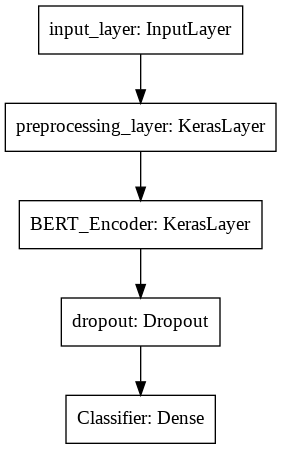

In [6]:
model = BuildClassifier(preprocessing=bert_preprocessing, model=bert_model).build()
tf.keras.utils.plot_model(model)

In [7]:
loss, metrics = tf.keras.losses.BinaryCrossentropy(from_logits=True), tf.metrics.BinaryAccuracy()


In [8]:
EPOCHS = 5
steps_per_epoch = tf.data.experimental.cardinality(data.train_ds).numpy()
train_steps = steps_per_epoch * EPOCHS
primer_steps = int(0.1*train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=train_steps,
                                          num_warmup_steps=primer_steps,
                                          optimizer_type='adamw')


In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [11]:
history = model.fit(x=data.train_ds, validation_data=data.val_ds, epochs=EPOCHS)



Epoch 1/5
625/625 [==============================] - 160s 247ms/step - loss: 0.4820 - binary_accuracy: 0.7459 - val_loss: 0.3957 - val_binary_accuracy: 0.8350
Epoch 2/5
625/625 [==============================] - 152s 243ms/step - loss: 0.3279 - binary_accuracy: 0.8504 - val_loss: 0.3695 - val_binary_accuracy: 0.8406
Epoch 3/5
625/625 [==============================] - 152s 243ms/step - loss: 0.2496 - binary_accuracy: 0.8939 - val_loss: 0.4013 - val_binary_accuracy: 0.8488
Epoch 4/5
625/625 [==============================] - 151s 242ms/step - loss: 0.1904 - binary_accuracy: 0.9262 - val_loss: 0.4627 - val_binary_accuracy: 0.8482
Epoch 5/5
625/625 [==============================] - 151s 242ms/step - loss: 0.1511 - binary_accuracy: 0.9424 - val_loss: 0.4811 - val_binary_accuracy: 0.8532


In [12]:
loss, accuracy = model.evaluate(data.test_ds)
print(f'Loss: {loss} || Accuracy: {accuracy}')



782/782 [==============================] - 84s 108ms/step - loss: 0.4665 - binary_accuracy: 0.8544
Loss: 0.46650683879852295 || Accuracy: 0.8543999791145325
